### Combining MTA and Census Data
First, load pickled dataframes

In [1]:
import pandas as pd
import pickle
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def open_file(filepath, filename):
    with open(filepath + filename, 'rb') as picklefile: 
        df = pickle.load(picklefile)
    return df

In [3]:
filepath_pickled_folder = '/Users/Joe/Documents/Metis/Projects/metis-one-Benson/pickled-dataframes/'
#filepath_raw = '/Users/Joe/Documents/Metis/Projects/metis-project-one/'

In [5]:
morning_rush_average = open_file(filepath_pickled_folder, 'morning_df.pkl')
evening_rush_average = open_file(filepath_pickled_folder, 'evening_df.pkl')
census = open_file(filepath_pickled_folder, 'census_pkl.pkl')
#mta = open_file(filepath_pickled_folder, 'MTA_stations.pkl')
locations = open_file(filepath_pickled_folder, 'zip-code-to-station.pkl')

In [6]:
# Column names should match
locations.rename(columns={'zipcode': 'zip code'}, inplace=True)
locations.rename(columns={'station_linename': 'station linename'}, inplace=True)

### Merge DataFrames

In [7]:
zip_code = locations.merge(census, how='left', on='zip code')

In [8]:
morning_rush_average = morning_rush_average.merge(zip_code, how='left', on = 'station linename')
evening_rush_average = evening_rush_average.merge(zip_code, how='left', on = 'station linename')

### Calculate a score for each station
Calculate percentiles for each feature, then calculate a weighted average of the percentiles

In [9]:
columns = ['Average Entries Per Hour',
           'Average Exits Per Hour',
           'Demographic',
           'Median income (dollars); Estimate; Households']

In [10]:
for column in columns:
    morning_rush_average[column + ', Percentile'] = morning_rush_average[column].rank(pct=True)
    evening_rush_average[column + ', Percentile'] = evening_rush_average[column].rank(pct=True)

In [11]:
def score(weights=[0.5, 0.3, 0.2]):
    person_wgt = weights[0]
    demo_wgt   = weights[1]
    money_wgt  = weights[2]
    
    morning_rush_average['Score'] = (person_wgt * morning_rush_average['Average Entries Per Hour, Percentile'] + 
                                     demo_wgt   * morning_rush_average['Demographic, Percentile'] + 
                                     money_wgt  * morning_rush_average['Median income (dollars); Estimate; Households, Percentile'])
    
    evening_rush_average['Score'] = (person_wgt * evening_rush_average['Average Exits Per Hour, Percentile'] + 
                                     demo_wgt   * evening_rush_average['Demographic, Percentile'] + 
                                     money_wgt  * evening_rush_average['Median income (dollars); Estimate; Households, Percentile'])

In [12]:
columns_to_drop = ['cumm. entries',
                   'cumm. exits',
                   'day',
                   'entries',
                   'exits',
                   'people',
                   'timedelta',
                   'entries per hour',
                   'exits per hour',
                   'people per hour']

In [13]:
morning_rush_average.drop(columns_to_drop, axis=1, inplace = True)
evening_rush_average.drop(columns_to_drop, axis=1, inplace = True)

In [14]:
score(weights=[0.4, 0.4, 0.2])

### And, here are our rankings!

In [15]:
morning_rankings = morning_rush_average.sort_values('Score', ascending=False)['station linename']

In [16]:
evening_rankings = evening_rush_average.sort_values('Score', ascending=False)['station linename']

In [17]:
for i, station in enumerate(morning_rankings[0:15]):
    #print(str(i) + ': ' + station)
    print(station)

TIMES SQ-42 ST 1237ACENQRS
34 ST-PENN STA 123
34 ST-PENN STA ACE
34 ST-HERALD SQ BDFMNQRW
FULTON ST 2345ACJZ
KEW GARDENS EF
CHAMBERS ST ACE23
42 ST-PORT AU ACE
23 ST FM
BROOKLYN BRIDGE 456JZ
WALL ST 23
CHAMBERS ST 123
30 AV NQW
ASTORIA BLVD NQW
46 ST BLISS ST 7


In [18]:
for i, station in enumerate(evening_rankings[0:15]):
    #print(str(i) + ': ' + station)
    print(station)

TIMES SQ-42 ST 1237ACENQRS
WALL ST 23
CHAMBERS ST ACE23
WALL ST 45
CHAMBERS ST 123
BROOKLYN BRIDGE 456JZ
WORLD TRADE CTR ACE23
5 AVE 7BDFM
FULTON ST 2345ACJZ
34 ST-HERALD SQ BDFMNQRW
23 ST FM
34 ST-PENN STA ACE
34 ST-PENN STA 123
23 ST NRW
CORTLANDT ST RNW


### Save Data

In [19]:
def save_file(df, filepath, filename):
    with open(filepath + filename, 'wb') as picklefile:
        pickle.dump(df, picklefile)

In [20]:
save_file(morning_rush_average, filepath_pickled_folder, 'morning_rush_rankings.pkl')
save_file(evening_rush_average, filepath_pickled_folder, 'evening_rush_rankings.pkl')

### Plotting the Stations

In [21]:
morning_rush_average.head()

,station linename,Start Date,End Date,Average Entries Per Hour,Average Exits Per Hour,Average People Per Hour,station,linename,coordinates,zip code,Percent Female Aged 20 to 34,Percent Females; Estimate; Science and Engineering Related Fields,Demographic,Median income (dollars); Estimate; Households,"Average Entries Per Hour, Percentile","Average Exits Per Hour, Percentile","Demographic, Percentile","Median income (dollars); Estimate; Households, Percentile",Score
0,1 AV L,2017-05-01 08:00:00,2017-06-23 12:00:00,1214.382075,1214.382075,2866.405660,1 AV,L,"(-73.98168087489128, 40.73097497580066)",10009,0.059476,7.0,0.004163,59090.0,0.840764,0.840764,0.550971,0.650485,0.686791
1,103 ST 1,2017-05-01 09:00:00,2017-06-23 09:00:00,608.492138,608.492138,747.522013,103 ST,1,"(-73.96837899960818, 40.799446000334825)",10025,0.028626,4.3,0.001231,74065.0,0.547771,0.547771,0.010922,0.743932,0.372264
2,103 ST 6,2017-05-01 09:00:00,2017-06-23 09:00:00,664.051887,664.051887,1109.820755,103 ST,6,"(-73.94747800152219, 40.79060000008452)",10029,0.034448,9.6,0.003307,31350.0,0.590234,0.590234,0.322816,0.135922,0.392404
3,103 ST BC,2017-05-01 09:00:00,2017-06-23 09:00:00,288.831761,288.831761,355.860063,103 ST,ABC,"(-73.96137008267617, 40.796060739904526)",83,NaN,NaN,NaN,NaN,0.225053,0.225053,NaN,NaN,NaN
4,103 ST-CORONA 7,2017-05-01 08:00:00,2017-06-23 12:00:00,2504.559748,2504.559748,2909.839623,103 ST-CORONA PL,7,"(-73.86269999830412, 40.749865000555545)",11368,0.022980,11.3,0.002597,45004.0,0.961783,0.961783,0.152913,0.432039,0.532286


In [22]:
zip_code['station_linename'] = zip_code['station'] + ' ' + zip_code['linename']
zip_code['Demographic, Percentile'] = zip_code['Demographic'].rank(pct=True)
zip_code['Median income (dollars); Estimate; Households, Percentile'] = zip_code['Median income (dollars); Estimate; Households'].rank(pct=True)

In [23]:
zip_code_station = zip_code.groupby('zip code').min().reset_index()

In [26]:
x_morn = morning_rush_average['Demographic, Percentile']
y_morn = morning_rush_average['Average Entries Per Hour, Percentile']
stations_morn = morning_rush_average['station linename']

x_even = evening_rush_average['Demographic, Percentile']
y_even = evening_rush_average['Average Exits Per Hour, Percentile']
stations_even = evening_rush_average['station linename']

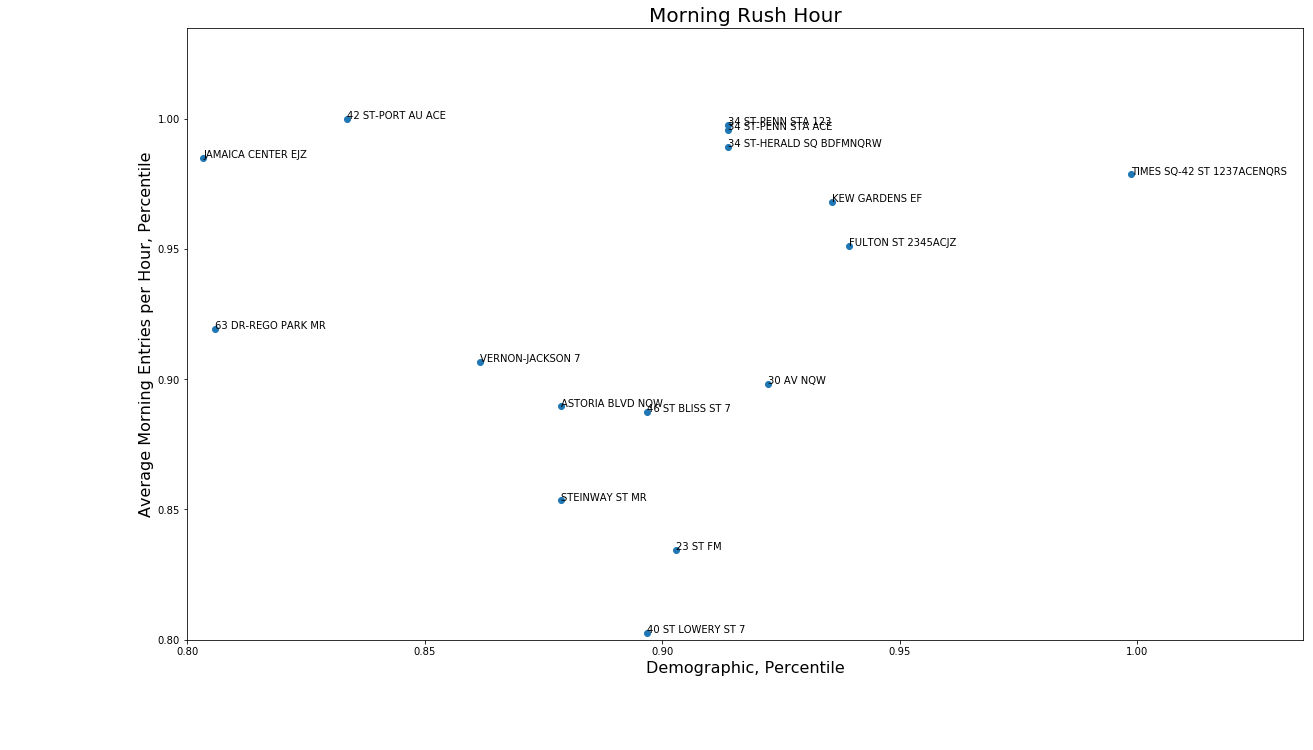

In [27]:
fig, ax = plt.subplots(figsize=(16*1.25, 9*1.25))
ax.scatter(x_morn, y_morn)

range = (0.8, 1.035)
ax.set_xlim(range)
ax.set_ylim(range)

ax.set_xlabel('Demographic, Percentile', fontsize=16)
ax.set_ylabel('Average Morning Entries per Hour, Percentile', fontsize=16)
ax.set_title('Morning Rush Hour', fontsize=20)

for i, txt in enumerate(stations_morn):
    ax.annotate(txt, (x_morn[i],y_morn[i]))

#plt.savefig('Morning Rush Hour vs Demographic.png')

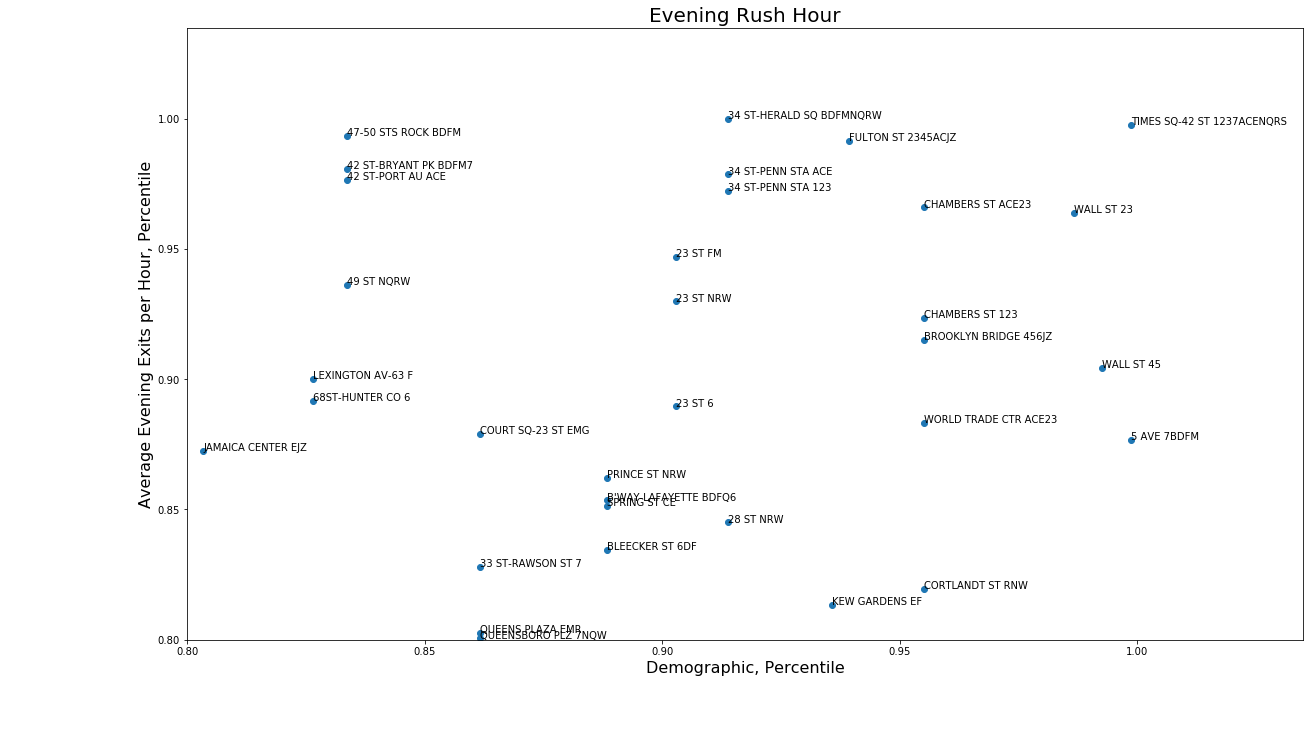

In [28]:
fig, ax = plt.subplots(figsize=(16*1.25, 9*1.25))
ax.scatter(x_even, y_even)

ax.set_xlim(range)
ax.set_ylim(range)

ax.set_xlabel('Demographic, Percentile', fontsize=16)
ax.set_ylabel('Average Evening Exits per Hour, Percentile', fontsize=16)
ax.set_title('Evening Rush Hour', fontsize=20) 

for i, txt in enumerate(stations_even):
    ax.annotate(txt, (x_even[i],y_even[i]))
    
#plt.savefig('Evening Rush Hour vs Demographic.png')